In [79]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [80]:
%cd drive/MyDrive/zop
!ls

[Errno 2] No such file or directory: 'drive/MyDrive/zop'
/content/drive/MyDrive/zop
diabetes.csv  projekt.ipynb


In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

# Exploratory data analysis

In [82]:
df = pd.read_csv('./diabetes.csv')

In [83]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [84]:
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [85]:
df.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [86]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


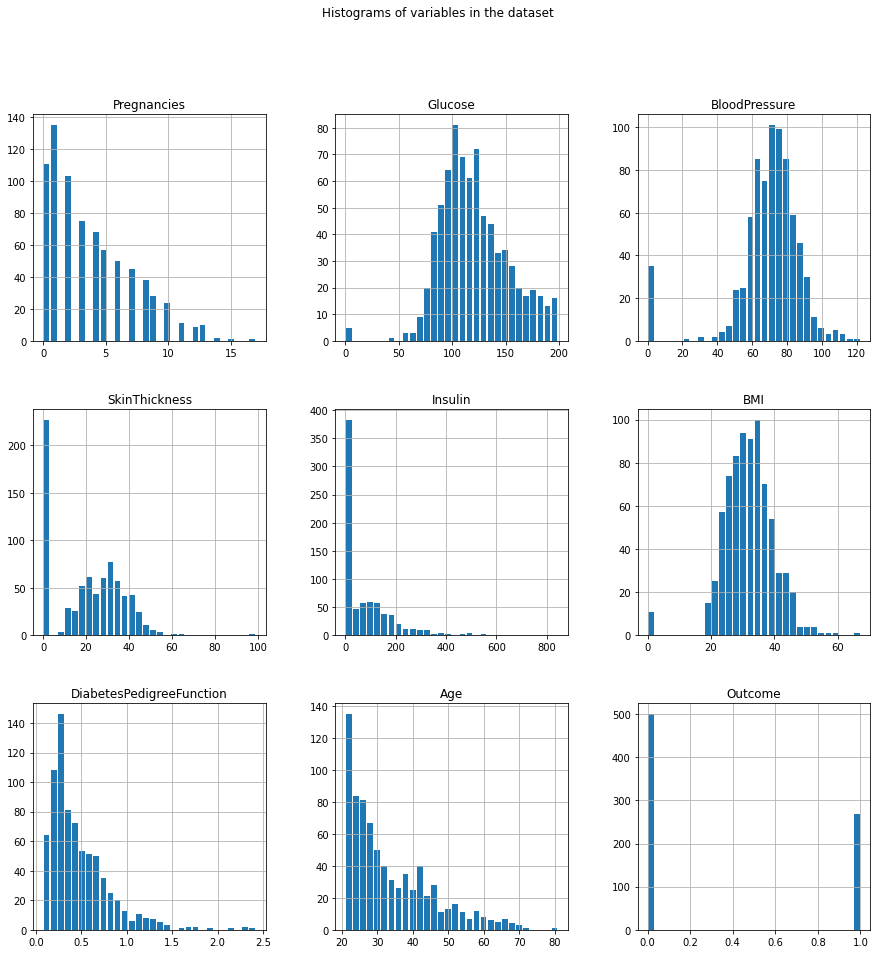

In [87]:
df.hist(bins=30, figsize=(15, 15), rwidth=0.8)
plt.suptitle('Histograms of variables in the dataset');

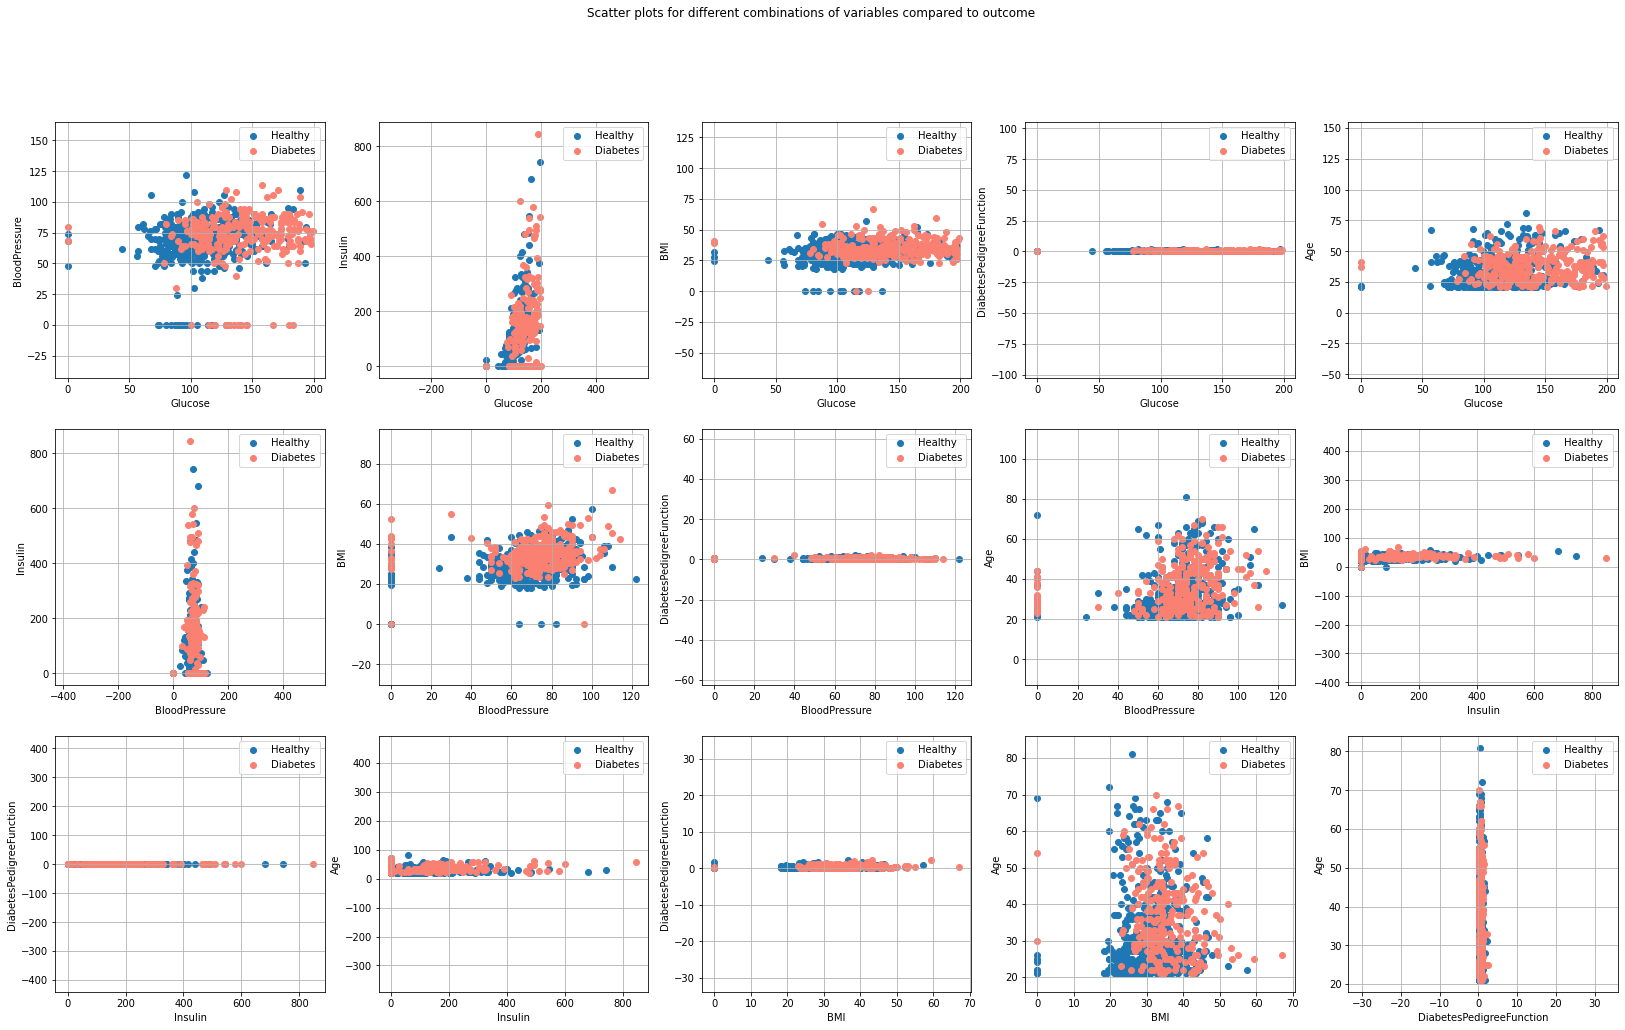

In [88]:
fig, axs = plt.subplots(3, 5, figsize=(28, 16))
axs = axs.reshape(-1)

columns = ['Glucose', 'BloodPressure', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

mask = df.Outcome == 1

k = 0
for i, _ in enumerate(columns):
    for j in range(i+1, len(columns)):
        axs[k].scatter(
            df.loc[~mask, columns[i]].to_numpy(), 
            df.loc[~mask, columns[j]].to_numpy(), 
            label='Healthy'
        )

        axs[k].scatter(
            df.loc[mask, columns[i]].to_numpy(), 
            df.loc[mask, columns[j]].to_numpy(), 
            label='Diabetes',
            c='salmon'
        )

        axs[k].set_xlabel(columns[i])
        axs[k].set_ylabel(columns[j])
        axs[k].legend()
        axs[k].grid()
        axs[k].axis('equal')
        k += 1

fig.suptitle('Scatter plots for different combinations of variables compared to outcome')
plt.show()

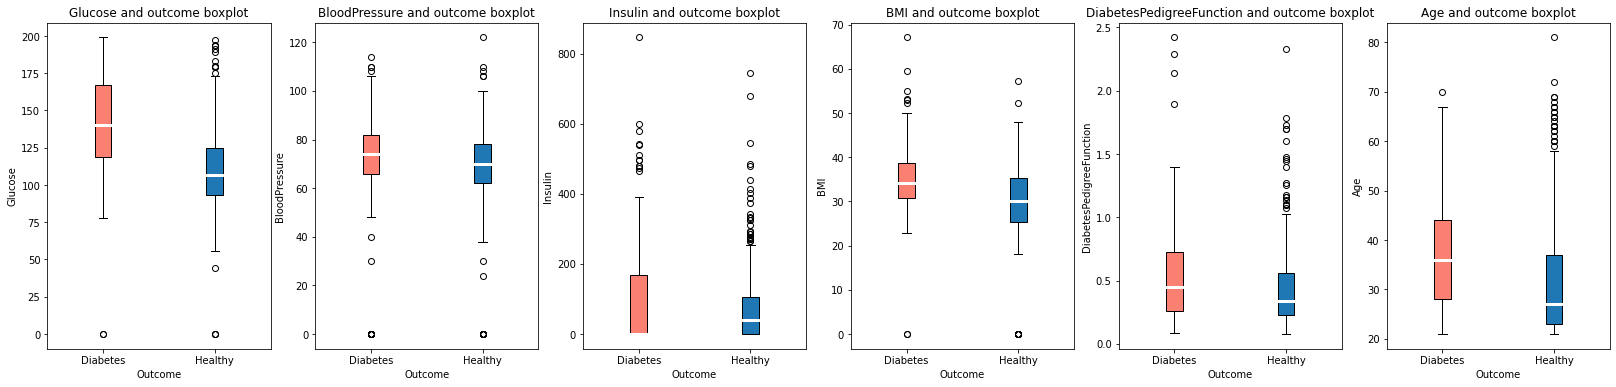

In [89]:
import warnings
warnings.filterwarnings('ignore')

d = {v: (df.loc[mask, v].tolist(), df.loc[~mask, v].tolist()) for v in columns}

fig, axs = plt.subplots(1, len(columns), figsize=(28, 6))
colors = ['salmon', 'C0']

for i, (k, v) in enumerate(d.items()):
    b = axs[i].boxplot(v, patch_artist=True, medianprops=dict(color='white', linewidth=3))
    for patch, color in zip(b['boxes'], colors):
        patch.set_facecolor(color)

    axs[i].set_xticklabels(['Diabetes', 'Healthy'])
    axs[i].set_title(columns[i] + ' and outcome boxplot')
    axs[i].set_ylabel(columns[i])
    axs[i].set_xlabel('Outcome')

plt.show()

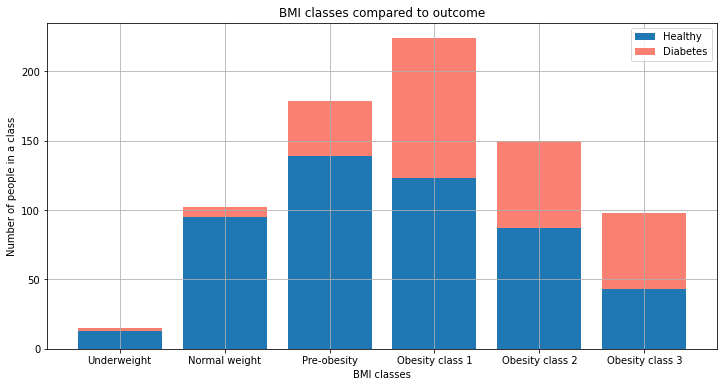

In [90]:
conditions_and_names = {
    'Underweight': df.BMI < 18.5, 
    'Normal weight': (df.BMI >= 18.5) & (df.BMI < 25), 
    'Pre-obesity': (df.BMI >= 25) & (df.BMI < 30),
    'Obesity class 1': (df.BMI >= 30) & (df.BMI < 35),
    'Obesity class 2': (df.BMI >= 35) & (df.BMI < 40),
    'Obesity class 3': df.BMI >= 40
}

plt.figure(figsize=(12, 6))
for n, c in conditions_and_names.items():
    count_df = df.loc[c].groupby('Outcome').count().iloc[:, 0].tolist()
    a = plt.bar(n, count_df[0], color=colors[1])
    b = plt.bar(n, count_df[1], color=colors[0], bottom=count_df[0])

plt.legend([a, b], ['Healthy', 'Diabetes'])
plt.ylabel('Number of people in a class')
plt.xlabel('BMI classes')
plt.title('BMI classes compared to outcome')
plt.grid()
plt.show()

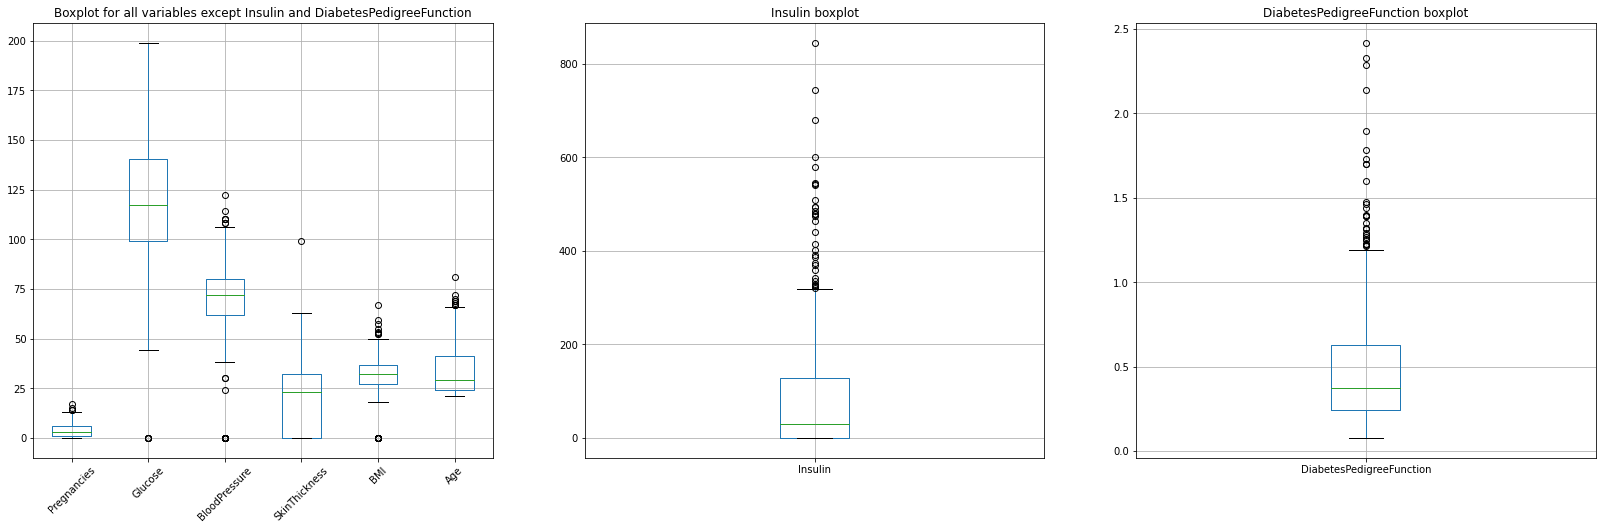

In [91]:
fig, axs = plt.subplots(1, 3, figsize=(28, 8))

df_no_insulin = df.drop(columns=['Insulin', 'DiabetesPedigreeFunction', 'Outcome'])
df_no_insulin.boxplot(ax=axs[0], rot=45)
axs[0].set_title('Boxplot for all variables except Insulin and DiabetesPedigreeFunction')

df.boxplot(column=['Insulin'], ax=axs[1])
axs[1].set_title('Insulin boxplot')

df.boxplot(column=['DiabetesPedigreeFunction'], ax=axs[2])
axs[2].set_title('DiabetesPedigreeFunction boxplot')

plt.show()

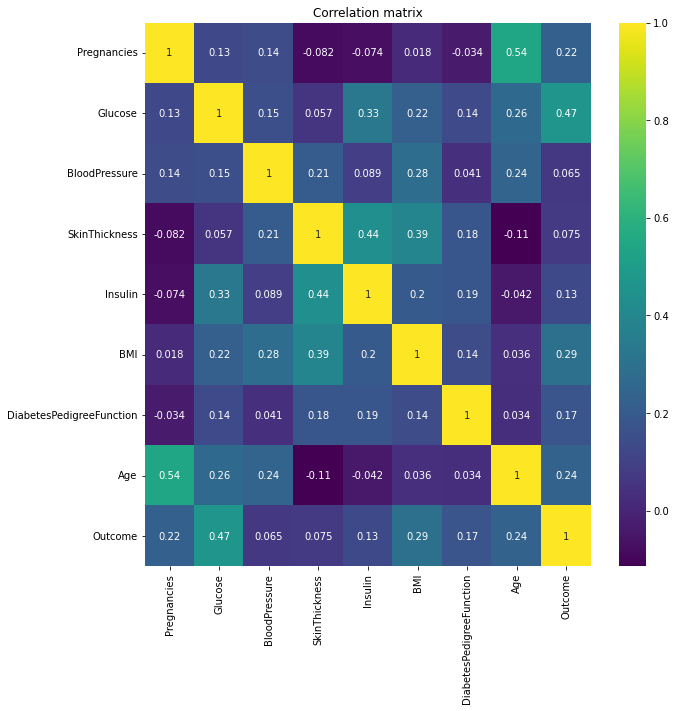

In [92]:
fig = plt.figure(figsize=(10, 10))
sb.heatmap(
    df.corr(),
    annot=True,
    cmap='viridis'
)
plt.title('Correlation matrix');

# SVM

In [93]:
X = df.drop('Outcome', axis=1)
y = df['Outcome'].to_numpy()

In [94]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline

X2 = StandardScaler().fit_transform(X)
svm = SVC()
params = {
    'C':[0.01*i for i in range(1, 100)],
    'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma':['scale', 'auto']
}

grid_search = GridSearchCV(svm, params, n_jobs=4, scoring='accuracy')
grid_search.fit(X2, y)
print(grid_search.best_params_)
print(grid_search.best_score_)

{'C': 0.47000000000000003, 'gamma': 'scale', 'kernel': 'rbf'}
0.7787029963500551


In [95]:
X2 = MinMaxScaler().fit_transform(X)
svm = SVC()
params = {
    'C':[0.01*i for i in range(1, 100)],
    'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma':['scale', 'auto']
}

grid_search = GridSearchCV(svm, params, n_jobs=4, scoring='accuracy')
grid_search.fit(X2, y)
print(grid_search.best_params_)
print(grid_search.best_score_)

{'C': 0.33, 'gamma': 'scale', 'kernel': 'rbf'}
0.7813003989474577


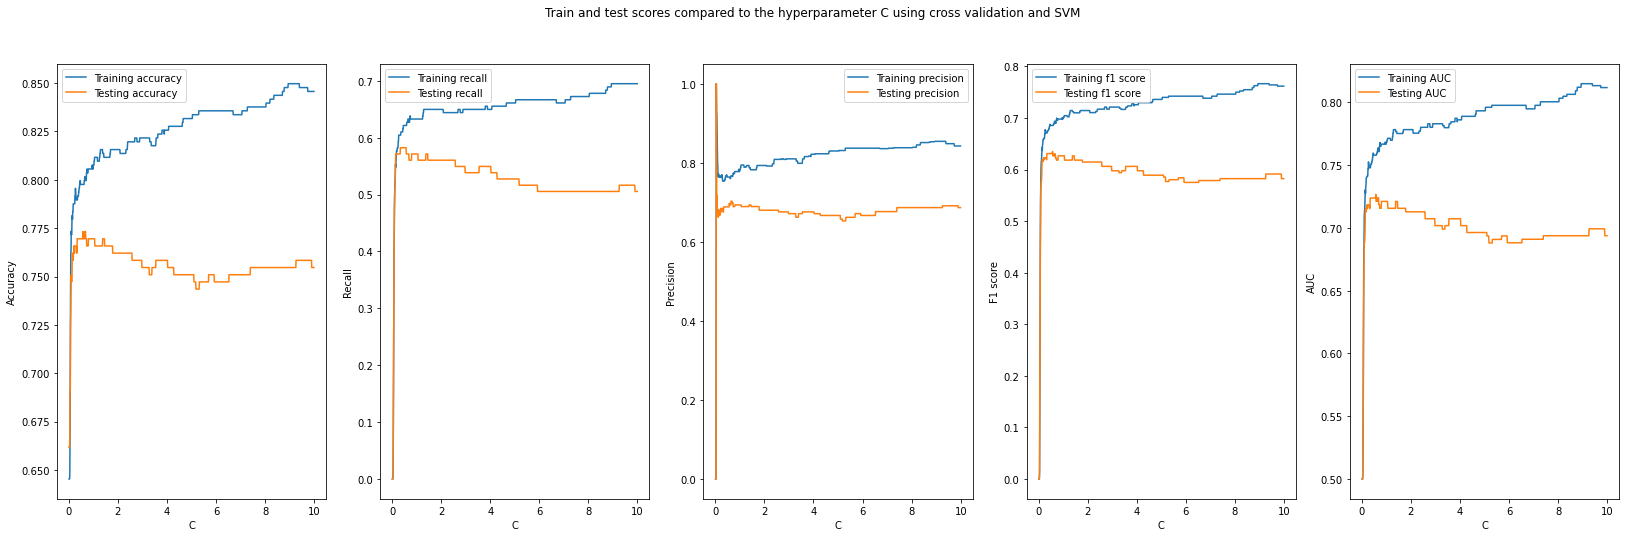

In [96]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split

def graph_metrics(alg_lambda, alg_name, xlabel, multiplier, X, y, x_labs=list(range(1, 1000))):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.35)

    acc_train, acc_test = [], []
    rec_train, rec_test = [], []
    prec_train, prec_test = [], []
    f1_train, f1_test = [], []
    auc_train, auc_test = [], []

    for i in x_labs:
        model = alg_lambda(i)
        model.fit(x_train, y_train)

        y_hat_train = model.predict(x_train)
        y_hat_test = model.predict(x_test)

        acc_train.append(accuracy_score(y_train, y_hat_train))
        acc_test.append(accuracy_score(y_test, y_hat_test))

        rec_train.append(recall_score(y_train, y_hat_train))
        rec_test.append(recall_score(y_test, y_hat_test))
        
        prec_train.append(precision_score(y_train, y_hat_train))
        prec_test.append(precision_score(y_test, y_hat_test))

        f1_train.append(f1_score(y_train, y_hat_train))
        f1_test.append(f1_score(y_test, y_hat_test))
        
        auc_train.append(roc_auc_score(y_train, y_hat_train))
        auc_test.append(roc_auc_score(y_test, y_hat_test))

    fig, axs = plt.subplots(1, 5, figsize=(28, 8))
    fig.suptitle(f'Train and test scores compared to the hyperparameter {xlabel} using cross validation and {alg_name}')
    x_val_lambda = lambda x: [x*i for i in x_labs]
    x_values = x_val_lambda(multiplier)

    axs[0].plot(x_values, acc_train, label='Training accuracy')
    axs[0].plot(x_values, acc_test, label='Testing accuracy')

    axs[1].plot(x_values, rec_train, label='Training recall')
    axs[1].plot(x_values, rec_test, label='Testing recall')

    axs[2].plot(x_values, prec_train, label='Training precision')
    axs[2].plot(x_values, prec_test, label='Testing precision')

    axs[3].plot(x_values, f1_train, label='Training f1 score')
    axs[3].plot(x_values, f1_test, label='Testing f1 score')

    axs[4].plot(x_values, auc_train, label='Training AUC')
    axs[4].plot(x_values, auc_test, label='Testing AUC')

    ys = ['Accuracy', 'Recall', 'Precision', 'F1 score', 'AUC']
    for ax, y_i in zip(axs, ys):
        ax.set_xlabel(xlabel)
        ax.set_ylabel(y_i)
        ax.legend()
    plt.show()

graph_metrics(lambda x: SVC(kernel='rbf', gamma='scale', C=0.01*x), 'SVM', 'C', 0.01, X2, y)

In [97]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.pipeline import make_pipeline

svm1 = make_pipeline(
    StandardScaler(),
    SVC(C=0.47, kernel='rbf', gamma='scale')
)

svm2 = make_pipeline(
    MinMaxScaler(),
    SVC(C=0.33, kernel='rbf', gamma='scale')
)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.35)

svm1.fit(x_train, y_train)
svm2.fit(x_train, y_train)

y_hat_train1 = svm1.predict(x_train)
y_hat_test1 = svm1.predict(x_test)

y_hat_train2 = svm2.predict(x_train)
y_hat_test2 = svm2.predict(x_test)

In [98]:
def print_metrics(y_hat_train, y_train, y_hat_test, y_test):
    print('Train confusion matrix:\n', confusion_matrix(y_hat_train, y_train))
    print('Train accuracy: ',accuracy_score(y_hat_train, y_train))
    print('-------------------------------------')

    print('Test confusion matrix:\n', confusion_matrix(y_hat_test, y_test))
    print('Test accuracy:', accuracy_score(y_hat_test, y_test))
    print('-------------------------------------')

    print(confusion_matrix(y_hat_train, y_train) + confusion_matrix(y_hat_test, y_test))

In [99]:
print('Prvi model:')
print_metrics(y_hat_train1, y_train, y_hat_test1, y_test)

print('======================================================================')

print('Drugi model:')
print_metrics(y_hat_train2, y_train, y_hat_test2, y_test)


Prvi model:
Train confusion matrix:
 [[292  68]
 [ 26 113]]
Train accuracy:  0.811623246492986
-------------------------------------
Test confusion matrix:
 [[158  37]
 [ 24  50]]
Test accuracy: 0.7732342007434945
-------------------------------------
[[450 105]
 [ 50 163]]
Drugi model:
Train confusion matrix:
 [[286  72]
 [ 32 109]]
Train accuracy:  0.7915831663326653
-------------------------------------
Test confusion matrix:
 [[155  38]
 [ 27  49]]
Test accuracy: 0.758364312267658
-------------------------------------
[[441 110]
 [ 59 158]]


# Naive Bayes Classifier

In [100]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB

In [101]:
nb = GaussianNB()
params = {
    'var_smoothing': [10**(-i) for i in range(1, 10)]
}

grid_search = GridSearchCV(nb, params, n_jobs=4, scoring='accuracy')
grid_search.fit(X, y)
print(grid_search.best_params_)
print(grid_search.best_score_)

{'var_smoothing': 0.001}
0.7552669552669553


In [102]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.35)

gnb = GaussianNB(var_smoothing=0.001)
gnb.fit(X, y)

y_hat_train = gnb.predict(x_train)
y_hat_test = gnb.predict(x_test)

print_metrics(y_hat_train, y_train, y_hat_test, y_test)

Train confusion matrix:
 [[272  77]
 [ 47 103]]
Train accuracy:  0.751503006012024
-------------------------------------
Test confusion matrix:
 [[159  36]
 [ 22  52]]
Test accuracy: 0.7843866171003717
-------------------------------------
[[431 113]
 [ 69 155]]


# Decision tree

In [103]:
from sklearn.tree import DecisionTreeClassifier

In [104]:
dtc = DecisionTreeClassifier()
params = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': list(range(2, 50)),
    'ccp_alpha': list(range(10))
}

grid_search = GridSearchCV(dtc, params, cv=15)
grid_search.fit(X, y)
print(grid_search.best_params_)

{'ccp_alpha': 0, 'criterion': 'gini', 'max_depth': 5, 'splitter': 'best'}


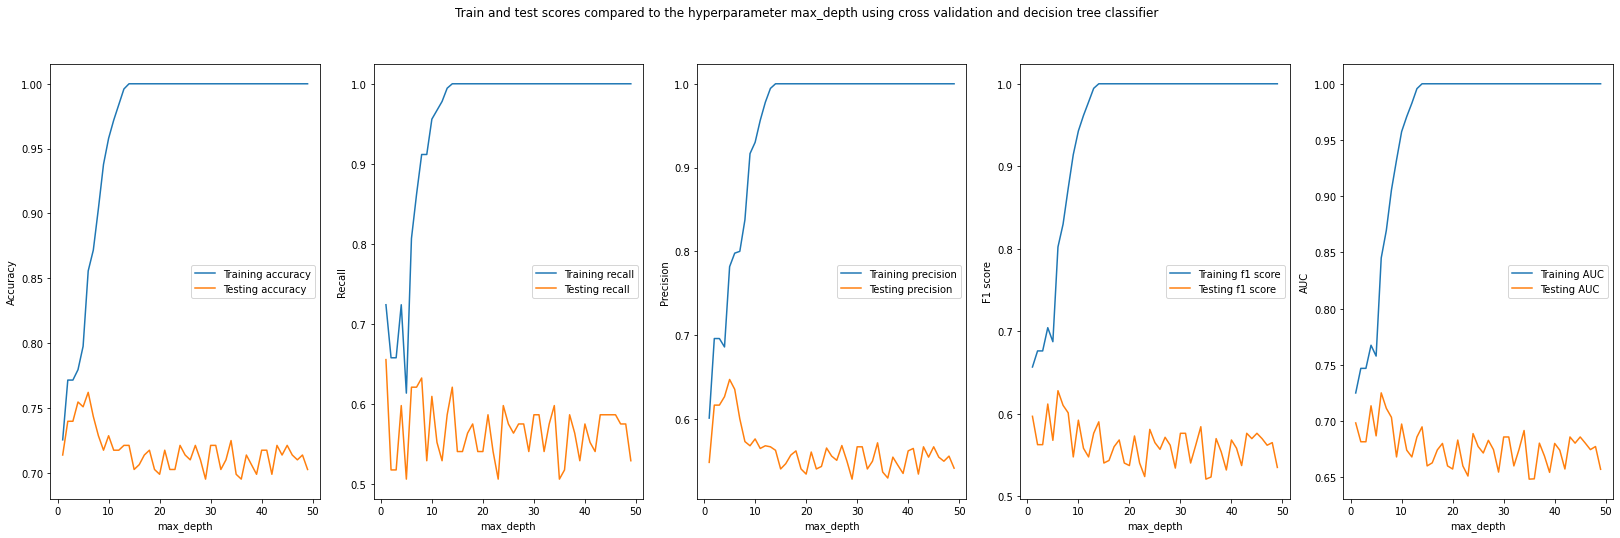

In [105]:
graph_metrics(lambda x: DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=x), 'decision tree classifier', 'max_depth', 1, X, y, x_labs=list(range(1, 50)))

In [106]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.35)

dtc = DecisionTreeClassifier(criterion='gini', max_depth=5, splitter='best')
dtc.fit(X, y)

y_hat_train = dtc.predict(x_train)
y_hat_test = dtc.predict(x_test)

print_metrics(y_hat_train, y_train, y_hat_test, y_test)

Train confusion matrix:
 [[295  52]
 [ 32 120]]
Train accuracy:  0.8316633266533067
-------------------------------------
Test confusion matrix:
 [[157  25]
 [ 16  71]]
Test accuracy: 0.8475836431226765
-------------------------------------
[[452  77]
 [ 48 191]]


# Accuracy measures

In [107]:
def print_accuracy_measures(alg, X, y):
    y_alg = alg.predict(X)
    d = {
         'Precision': precision_score(y, y_alg),
         'Recall': recall_score(y, y_alg),
         'F-measure': f1_score(y, y_alg),
         'Accuracy': accuracy_score(y, y_alg),
         'ROC': roc_auc_score(y, y_alg)
    }
    for name, value in d.items():
        print('{:>20s}: {:.3f}'.format(name, value))
    print()

print('SVM:')
print_accuracy_measures(svm2, X, y)

print('Naive Bayes classifier:')
print_accuracy_measures(gnb, X, y)

print('Decision tree classifier:')
print_accuracy_measures(dtc, X, y)

SVM:
           Precision: 0.728
              Recall: 0.590
           F-measure: 0.652
            Accuracy: 0.780
                 ROC: 0.736

Naive Bayes classifier:
           Precision: 0.692
              Recall: 0.578
           F-measure: 0.630
            Accuracy: 0.763
                 ROC: 0.720

Decision tree classifier:
           Precision: 0.799
              Recall: 0.713
           F-measure: 0.753
            Accuracy: 0.837
                 ROC: 0.808



In [108]:
cci = 'Correctly Classified Instances'
ici = 'Incorrectly Classified Instances'

def print_correct_and_incorrect(c):
    print('{:>35s}: {}'.format(cci, c[0][0] + c[1][1]))
    print('{:>35s}: {}'.format(ici, c[1][0] + c[0][1]))
    print()

print('Naive Bayes classifier:')
c = confusion_matrix(y, gnb.predict(X))
print_correct_and_incorrect(c)

print('SVM:')
c = confusion_matrix(y, svm2.predict(X))
print_correct_and_incorrect(c)

print('Decision tree classifier:')
c = confusion_matrix(y, dtc.predict(X))
print_correct_and_incorrect(c)

Naive Bayes classifier:
     Correctly Classified Instances: 586
   Incorrectly Classified Instances: 182

SVM:
     Correctly Classified Instances: 599
   Incorrectly Classified Instances: 169

Decision tree classifier:
     Correctly Classified Instances: 643
   Incorrectly Classified Instances: 125



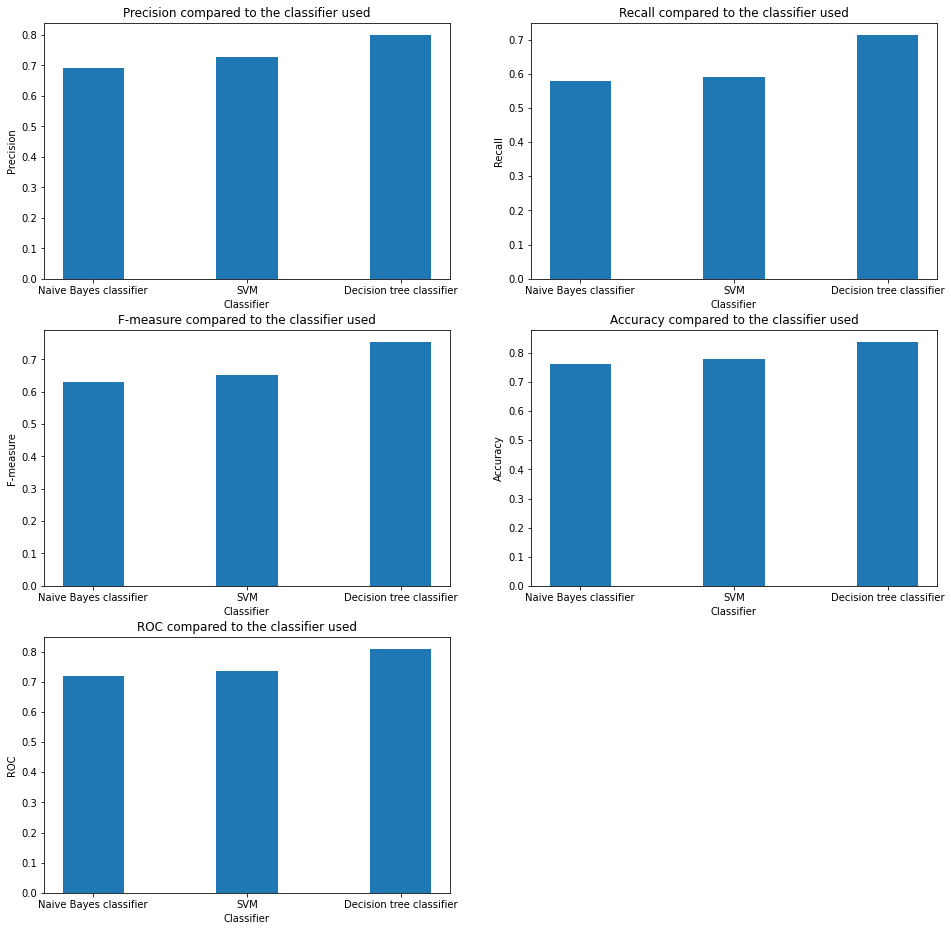

In [109]:
def create_metric_dict(alg, X):
    y_alg = alg.predict(X)
    return {
         'Precision': precision_score(y, y_alg),
         'Recall': recall_score(y, y_alg),
         'F-measure': f1_score(y, y_alg),
         'Accuracy': accuracy_score(y, y_alg),
         'ROC': roc_auc_score(y, y_alg)
    }

gnb_dict = create_metric_dict(gnb, X)
svm_dict = create_metric_dict(svm2, X)
dtc_dict = create_metric_dict(dtc, X)

pr = [gnb_dict['Precision'], svm_dict['Precision'], dtc_dict['Precision']]
re = [gnb_dict['Recall'], svm_dict['Recall'], dtc_dict['Recall']]
f = [gnb_dict['F-measure'], svm_dict['F-measure'], dtc_dict['F-measure']]
acc = [gnb_dict['Accuracy'], svm_dict['Accuracy'], dtc_dict['Accuracy']]
roc = [gnb_dict['ROC'], svm_dict['ROC'], dtc_dict['ROC']]
metrics = [pr, re, f, acc, roc]
names = ['Naive Bayes classifier', 'SVM', 'Decision tree classifier']

fig, axs = plt.subplots(3, 2, figsize=(16, 16))
fig.delaxes(axs[2, 1])

metric_names = list(gnb_dict.keys())
for i in range(2):
    for j in range(2):
        rects = axs[i, j].bar(names, metrics[i*2 + j], width=0.4)
        axs[i, j].set_title(metric_names[i*2 + j] + ' compared to the classifier used')
        axs[i, j].set_xlabel('Classifier')
        axs[i, j].set_ylabel(metric_names[i*2 + j])
        # axs[i, j].bar_label(rects, np.around(metrics[i*2 + j], 3), padding=3)

rects = axs[2, 0].bar(names, roc, width=0.4)
axs[2, 0].set_title('ROC compared to the classifier used')
axs[2, 0].set_xlabel('Classifier')
axs[2, 0].set_ylabel('ROC')
# axs[2, 0].bar_label(rects, np.around(roc, 3), padding=3)

plt.show()

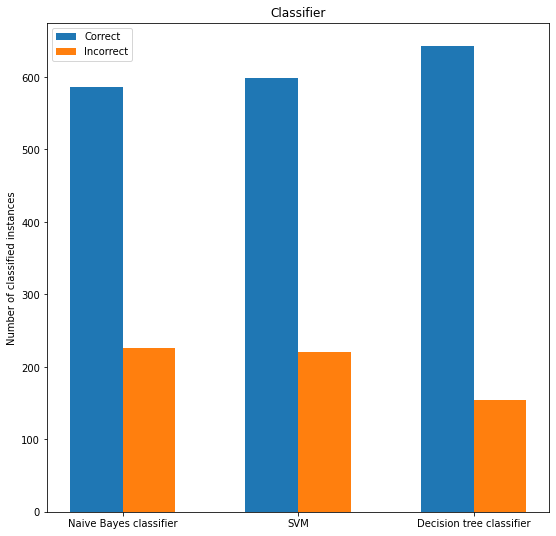

In [110]:
c_m = [
       confusion_matrix(y, gnb.predict(X)),
       confusion_matrix(y, svm2.predict(X)),
       confusion_matrix(y, dtc.predict(X))
]

ind = np.arange(len(c_m))
correct_f = lambda c: c[1][1] + c[0][0]
incorrect_f = lambda c: c[1][0] + c[1][0]

correct = [correct_f(c_i) for c_i in c_m]
incorrect = [incorrect_f(c_i) for c_i in c_m]

fig, ax = plt.subplots(figsize=(9, 9))

rects1 = ax.bar(ind - 0.15, correct, 0.3, label='Correct')
rects2 = ax.bar(ind + 0.15, incorrect, 0.3, label='Incorrect')

ax.set_ylabel('Number of classified instances')
ax.set_title('Classifier')
ax.set_xticks(ind)
ax.set_xticklabels(names)
ax.legend()

# ax.bar_label(rects1, correct, padding=3)
# ax.bar_label(rects2, incorrect, padding=3)

plt.show()